
# CTE — EDA 1 (Sanity Checks & First Insights)

This notebook loads the **cleaned dataset** produced by `src/cte/data.py` and runs first-pass EDA:
- sanity checks (shape, schema, missingness)
- quick plots (productivity over time, sleep vs productivity, mood distribution, meal quality vs productivity, interaction patterns)
- a small JSON summary for your report

> It will try to load `data/interim/clean.parquet`.
> If not found, it falls back to `data/sample/clean_sample.parquet`.



## How to run

1. Start JupyterLab from your project root:
   ```bash
   poetry run jupyter lab
   ```
2. Open this notebook and select the **Python (cte-project)** kernel.
3. Run → **Run All Cells**.


### Quick findings (Phase 1)

- Productivity varies strongly by weekday (early-week high, late-week low).
- More distinct “productive windows” → higher productivity medians.
- Meals: balanced dinner aligns with higher mean productivity; lunch effects are uncertain (wide CIs).
- Sleep: weak/near-zero linear associations with productivity (duration slightly negative).
- Mood: strong separation—“motivated/happy” days outperform “stressed/overwhelmed”.
- Social: interactions are mildly positive on average; “no-interaction” days are common and may matter as controls.


**Limitations (Phase 1):**
- N≈72 days → wide CIs and unstable correlations; treat effects as exploratory, not causal.
- Linear correlation only; non-linear/time-lagged effects not yet tested.
- Self-report bias possible; productivity percentage is subjective.


In [37]:
from pathlib import Path
import warnings, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Plot defaults
plt.rcParams.update({
    "figure.figsize": (8, 4),
    "axes.grid": True,         # grid helps readability
})

warnings.filterwarnings("ignore")

# 2) Make file locations robust no matter where the notebook is run from
CWD = Path.cwd()
# If we launched from repo root, this exists; if we're already inside notebooks/, parent holds it.
NB_BASE = (CWD / "notebooks") if (CWD / "notebooks").exists() else CWD

FIG_DIR = NB_BASE / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_PATH = NB_BASE / "reports" / "eda_summary.json"
SUMMARY_PATH.parent.mkdir(parents=True, exist_ok=True)

# 3) Only write a curated set of figures to disk (others still display inline)
KEEP = {
    # flagship / summary
    "prod_over_time.png",
    "prod_by_weekday.png",
    "prod_by_study_location.png",
    "prod_by_primary_mood_box.png",
    "prod_vs_num_prod_slots.png",

    # sleep vs productivity
    "sleep_duration_vs_productivity.png",
    "deep_sleep_pct_vs_prod.png",
    "rem_sleep_pct_vs_prod.png",

    # meals (CI versions only)
    "prod_by_breakfast_quality_ci.png",
    "prod_by_lunch_quality_ci.png",
    "prod_by_dinner_quality_ci.png",

    # distributions
    "primary_mood_distribution.png",
    "secondary_mood_distribution.png",
    "when_most_productive_distribution.png",

    # social interactions
    "partner_no_interaction_rate.png", "partner_score_mean.png",
    "family_no_interaction_rate.png",  "family_score_mean.png",
    "friends_no_interaction_rate.png", "friends_score_mean.png",
}

def savefig(path_like):
    """
    Save the current Matplotlib figure ONLY if the filename is in KEEP.
    Always shows inline; closes the figure to avoid memory leaks.
    Works whether you pass 'name.png' or FIG_DIR / 'name.png'.
    """
    p = Path(path_like)
    fname = p.name
    if fname in KEEP:
        (FIG_DIR / fname).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(FIG_DIR / fname, bbox_inches="tight", dpi=160)
    plt.show()
    plt.close()


In [38]:
from pathlib import Path
import pandas as pd

def find_project_root(start: Path | None = None) -> Path:
    p = start or Path.cwd()
    for parent in [p, *p.parents]:
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return p  # fallback: current directory

ROOT = find_project_root()
DATA = ROOT / "data"

parquet_path     = DATA / "interim" / "clean.parquet"
sample_parquet   = DATA / "sample"  / "clean_sample.parquet"
sample_csv       = DATA / "sample"  / "cte_sample.csv"

print("Detected ROOT:", ROOT)
print("Looking for:", parquet_path, sample_parquet, sample_csv, sep="\n - ")

def load_df():
    if parquet_path.exists():
        print(f"Loading: {parquet_path}")
        return pd.read_parquet(parquet_path)
    if sample_parquet.exists():
        print(f"Loading: {sample_parquet}")
        return pd.read_parquet(sample_parquet)
    if sample_csv.exists():
        print(f"Loading: {sample_csv}")
        return pd.read_csv(sample_csv)
    raise FileNotFoundError("No dataset found. Expected data/interim/clean.parquet or a sample in data/sample/.")

df = load_df()
print("Shape:", df.shape)
df.head(3)


Detected ROOT: /Users/deo/UMKC_phd/project_related/job_related/cte-project
Looking for:
 - /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/clean.parquet
 - /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/sample/clean_sample.parquet
 - /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/sample/cte_sample.csv
Loading: /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/clean.parquet
Shape: (72, 56)


,date,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,sleep_duration_h,productivity_pct,deep_sleep_pct,rem_sleep_pct,water_drank_l,studied_at_home,...,reflection,primary_mood,secondary_mood,when_most_productive,interaction_partner,interaction_family,interaction_friends,dinner_time,bed_time,wakeup_time
0,2025-01-27,393,1240,1335,7.633333,75.0,21.0,8.0,1.5,1,...,I think i did good today for my first day on t...,motivated,happy,1,positive,na,na,8:40 PM,10:15 PM,6:33 AM
1,2025-01-28,443,1215,1320,9.100000,0.0,21.0,5.0,1.0,0,...,"Well, i did pretty bad today, couldn't get goi...",happy,overwhelmed,5,positive,positive,positive,8:15 PM,10:00 PM,7:23 AM
2,2025-01-29,370,1230,1339,7.933333,10.0,21.0,4.0,1.8,1,...,"i started good, maybe for first few minutes an...",overwhelmed,sad,1,positive,na,positive,8:30 PM,10:19 PM,6:10 AM


In [39]:

print("Columns:", list(df.columns))
print("\nDtypes summary:")
print(df.dtypes.value_counts())

missing = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 10):")
print((missing.head(10) * 100).round(1).astype(str) + "%")


Columns: ['date', 'wakeup_time_minutes', 'dinner_time_minutes', 'bed_time_minutes', 'sleep_duration_h', 'productivity_pct', 'deep_sleep_pct', 'rem_sleep_pct', 'water_drank_l', 'studied_at_home', 'studied_at_school', 'workout_did', 'meditation', 'morning_shower', 'played_sports', 'sickness', 'nap_today', 'partner_score', 'partner_no_interaction', 'family_score', 'family_no_interaction', 'friends_score', 'friends_no_interaction', 'breakfast_no_meal', 'breakfast_carb_heavy', 'breakfast_protein_heavy', 'breakfast_fat_heavy', 'breakfast_balanced', 'lunch_no_meal', 'lunch_carb_heavy', 'lunch_protein_heavy', 'lunch_fat_heavy', 'lunch_balanced', 'dinner_no_meal', 'dinner_carb_heavy', 'dinner_protein_heavy', 'dinner_fat_heavy', 'dinner_balanced', 'breakfast_quality', 'lunch_quality', 'dinner_quality', 'when_most_productive_decoded', 'prod_morning', 'prod_afternoon', 'prod_evening', 'prod_none', 'reflection', 'primary_mood', 'secondary_mood', 'when_most_productive', 'interaction_partner', 'inter

In [40]:

if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)
    print("Date range:", df["date"].min(), "→", df["date"].max())
else:
    print("No 'date' column found — time-based charts will be skipped.")


Date range: 2025-01-27 00:00:00 → 2025-04-30 00:00:00


In [41]:

def savefig(fig, name):
    out = FIG_DIR / name
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {out}")


In [42]:

if "date" in df.columns and "productivity_pct" in df.columns:
    s = df[["date", "productivity_pct"]].dropna()
    fig, ax = plt.subplots()
    ax.plot(s["date"], s["productivity_pct"], marker="o", linewidth=1)
    if len(s) >= 7:
        roll = s.set_index("date")["productivity_pct"].rolling(7, min_periods=3).mean()
        ax.plot(roll.index, roll.values, linewidth=2)
        ax.legend(["daily", "7d rolling"], loc="best")
    ax.set_title("Productivity % over time")
    ax.set_ylabel("productivity %")
    ax.set_xlabel("date")
    ax.grid(True, alpha=0.3)
    savefig(fig, "prod_over_time.png")
else:
    print("Skipping productivity-over-time plot (missing columns).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_over_time.png


In [43]:

if all(c in df.columns for c in ["sleep_duration_h", "productivity_pct"]):
    s = df[["sleep_duration_h", "productivity_pct"]].dropna()
    fig, ax = plt.subplots()
    ax.scatter(s["sleep_duration_h"], s["productivity_pct"], alpha=0.7)
    if len(s) >= 2:
        r = s["sleep_duration_h"].corr(s["productivity_pct"])
        ax.set_title(f"Sleep (h) vs Productivity (%)  —  r = {r:.2f}")
    else:
        ax.set_title("Sleep (h) vs Productivity (%)")
    ax.set_xlabel("sleep_duration_h")
    ax.set_ylabel("productivity_pct")
    ax.grid(True, alpha=0.3)
    savefig(fig, "sleep_vs_prod.png")
else:
    print("Skipping sleep vs productivity (missing columns).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/sleep_vs_prod.png


In [44]:

for stage in ["deep_sleep_pct", "rem_sleep_pct"]:
    if stage in df.columns and "productivity_pct" in df.columns:
        s = df[[stage, "productivity_pct"]].dropna()
        if not s.empty:
            fig, ax = plt.subplots()
            ax.scatter(s[stage], s["productivity_pct"], alpha=0.7)
            if len(s) >= 2:
                r = s[stage].corr(s["productivity_pct"])
                ax.set_title(f"{stage} vs Productivity (%)  —  r = {r:.2f}")
            else:
                ax.set_title(f"{stage} vs Productivity (%)")
            ax.set_xlabel(stage)
            ax.set_ylabel("productivity_pct")
            ax.grid(True, alpha=0.3)
            savefig(fig, f"{stage}_vs_prod.png")
        else:
            print(f"Skipping {stage} vs productivity (no overlap).")
    else:
        print(f"Skipping {stage} vs productivity (missing columns).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/deep_sleep_pct_vs_prod.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/rem_sleep_pct_vs_prod.png


In [45]:

def mean_by_label(label_col):
    tmp = df[[label_col, "productivity_pct"]].dropna()
    if tmp.empty: 
        return None
    out = tmp.groupby(label_col, dropna=False)["productivity_pct"].mean().sort_values(ascending=False)
    return out

for meal in ["breakfast_quality", "lunch_quality", "dinner_quality"]:
    if meal in df.columns and "productivity_pct" in df.columns:
        means = mean_by_label(meal)
        if means is not None:
            fig, ax = plt.subplots()
            means.plot(kind="bar", ax=ax)
            ax.set_title(f"Average Productivity by {meal}")
            ax.set_ylabel("mean productivity %")
            ax.set_xlabel(meal)
            ax.grid(True, axis="y", alpha=0.3)
            savefig(fig, f"prod_by_{meal}.png")
        else:
            print(f"Skipping plot for {meal} (no data).")
    else:
        print(f"Skipping plot for {meal} (missing columns).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_breakfast_quality.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_lunch_quality.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_dinner_quality.png


In [46]:

for mood_col in ["primary_mood", "secondary_mood"]:
    if mood_col in df.columns:
        counts = df[mood_col].dropna().astype(str).str.lower().value_counts()
        if not counts.empty:
            fig, ax = plt.subplots()
            counts.plot(kind="bar", ax=ax)
            ax.set_title(f"{mood_col} distribution")
            ax.set_ylabel("count")
            ax.grid(True, axis="y", alpha=0.3)
            savefig(fig, f"{mood_col}_distribution.png")
        else:
            print(f"Skipping {mood_col} distribution (no values).")
    else:
        print(f"Skipping {mood_col} distribution (missing column).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/primary_mood_distribution.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/secondary_mood_distribution.png


In [47]:

pairs = [
    ("partner_score", "partner_no_interaction"),
    ("family_score", "family_no_interaction"),
    ("friends_score", "friends_no_interaction"),
]

for score_col, naflag_col in pairs:
    if score_col in df.columns and naflag_col in df.columns:
        s = df[[score_col, naflag_col]].dropna(subset=[score_col])
        if not s.empty:
            # Mean interaction score
            fig, ax = plt.subplots()
            ax.bar(["mean_score"], [s[score_col].mean()])
            ax.set_ylim(-1, 1)
            ax.set_title(f"{score_col}: mean interaction score")
            ax.grid(True, axis="y", alpha=0.3)
            savefig(fig, f"{score_col}_mean.png")
            # No interaction rate
            fig, ax = plt.subplots()
            rate = s[naflag_col].mean()
            ax.bar(["no_interaction_rate"], [rate])
            ax.set_ylim(0, 1)
            ax.set_title(f"{naflag_col}: fraction of days with no interaction")
            ax.grid(True, axis="y", alpha=0.3)
            savefig(fig, f"{naflag_col}_rate.png")
        else:
            print(f"Skipping interaction charts for {score_col}/{naflag_col} (no data).")
    else:
        print(f"Skipping interaction charts for {score_col}/{naflag_col} (missing columns).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/partner_score_mean.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/partner_no_interaction_rate.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/family_score_mean.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/family_no_interaction_rate.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/friends_score_mean.png
Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/friends_no_interaction_rate.png


In [48]:

col = "when_most_productive_decoded"
if col in df.columns:
    counts = df[col].astype(str).value_counts()
    if not counts.empty:
        fig, ax = plt.subplots()
        counts.plot(kind="bar", ax=ax)
        ax.set_title("When most productive (decoded) — distribution")
        ax.set_ylabel("count")
        ax.grid(True, axis="y", alpha=0.3)
        savefig(fig, "when_most_productive_distribution.png")
    else:
        print("Skipping 'when_most_productive_decoded' dist (no values).")
else:
    print("Skipping 'when_most_productive_decoded' dist (missing column).")


Saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/when_most_productive_distribution.png


In [49]:

summary = {}

# Date range
if "date" in df.columns and not df["date"].isna().all():
    summary["date_min"] = pd.to_datetime(df["date"]).min().strftime("%Y-%m-%d")
    summary["date_max"] = pd.to_datetime(df["date"]).max().strftime("%Y-%m-%d")

# Correlations (where available)
for pair in [
    ("sleep_duration_h", "productivity_pct"),
    ("deep_sleep_pct", "productivity_pct"),
    ("rem_sleep_pct", "productivity_pct"),
]:
    a, b = pair
    if a in df.columns and b in df.columns:
        s = df[[a, b]].dropna()
        if len(s) >= 2:
            summary[f"corr_{a}_vs_{b}"] = round(float(s[a].corr(s[b])), 3)

# Meal means
for meal in ["breakfast_quality", "lunch_quality", "dinner_quality"]:
    if meal in df.columns and "productivity_pct" in df.columns:
        tmp = df[[meal, "productivity_pct"]].dropna()
        if not tmp.empty:
            means = tmp.groupby(meal)["productivity_pct"].mean().round(2).to_dict()
            summary[f"mean_prod_by_{meal}"] = means

# Save
with open(SUMMARY_PATH, "w") as f:
    json.dump(summary, f, indent=2)
print("Wrote:", SUMMARY_PATH)
print(json.dumps(summary, indent=2))


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/eda_summary.json
{
  "date_min": "2025-01-27",
  "date_max": "2025-04-30",
  "corr_sleep_duration_h_vs_productivity_pct": -0.288,
  "corr_deep_sleep_pct_vs_productivity_pct": -0.138,
  "corr_rem_sleep_pct_vs_productivity_pct": 0.018,
  "mean_prod_by_breakfast_quality": {
    "balanced": 32.69,
    "carb_heavy": 40.82,
    "protein_heavy": 28.89
  },
  "mean_prod_by_lunch_quality": {
    "balanced": 41.17,
    "carb_heavy": 37.6,
    "protein_heavy": 52.5
  },
  "mean_prod_by_dinner_quality": {
    "balanced": 48.91,
    "carb_heavy": 36.82,
    "protein_heavy": 27.17
  }
}


# Stats Sanity
Quick hypothesis checks

## Pearson & Spearman correlations + p-values

In [50]:
from scipy import stats
pairs = [
    ("sleep_duration_h", "productivity_pct"),
    ("deep_sleep_pct",   "productivity_pct"),
    ("rem_sleep_pct",    "productivity_pct"),
]
for a, b in pairs:
    s = df[[a, b]].dropna()
    if len(s) >= 3:
        r,  p  = stats.pearsonr(s[a], s[b])
        rho, ps = stats.spearmanr(s[a], s[b])
        print(f"{a} vs {b}: Pearson r={r:.3f} (p={p:.3g}), "
              f"Spearman ρ={rho:.3f} (p={ps:.3g}), n={len(s)}")


sleep_duration_h vs productivity_pct: Pearson r=-0.288 (p=0.0142), Spearman ρ=-0.161 (p=0.175), n=72
deep_sleep_pct vs productivity_pct: Pearson r=-0.138 (p=0.247), Spearman ρ=-0.079 (p=0.508), n=72
rem_sleep_pct vs productivity_pct: Pearson r=0.018 (p=0.88), Spearman ρ=0.025 (p=0.835), n=72


## Non-parametric test for meal quality vs productivity
We use Kruskal–Wallis; it’s robust with small sample sizes and non-normal data.

In [51]:
from scipy import stats
for meal in ["breakfast_quality","lunch_quality","dinner_quality"]:
    tmp = df[[meal, "productivity_pct"]].dropna()
    groups = [g["productivity_pct"].values for _, g in tmp.groupby(meal)]
    if len(groups) >= 2:
        stat, p = stats.kruskal(*groups)
        print(f"{meal}: Kruskal–Wallis H={stat:.2f}, p={p:.3g}, k={len(groups)}")


breakfast_quality: Kruskal–Wallis H=1.23, p=0.54, k=3
lunch_quality: Kruskal–Wallis H=0.34, p=0.845, k=3
dinner_quality: Kruskal–Wallis H=2.60, p=0.272, k=3


With ~72 days, p-values are directional context rather than hard claims. I use them to prioritize which relationships to explore further in Feature Engineering.


## Weekday pattern

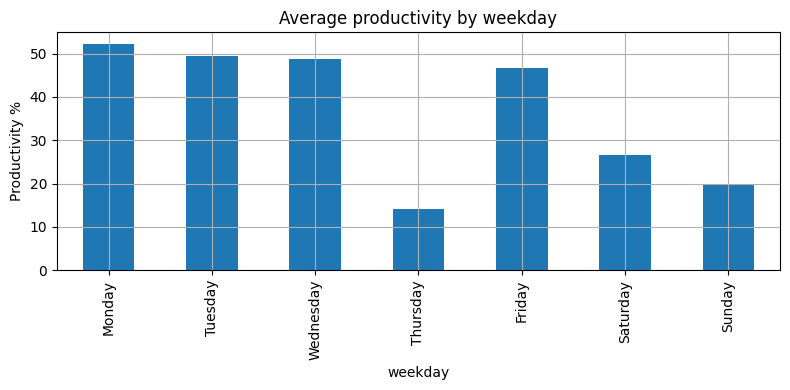

In [52]:
import matplotlib.pyplot as plt
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["weekday"] = pd.to_datetime(df["date"]).dt.day_name()
means = df.groupby("weekday")["productivity_pct"].mean().reindex(order)
ax = means.plot(kind="bar")
ax.set_title("Average productivity by weekday")
ax.set_ylabel("Productivity %")
plt.tight_layout()
plt.savefig("reports/figures/prod_by_weekday.png", dpi=150)
plt.show()


## “Number of productive slots” vs productivity

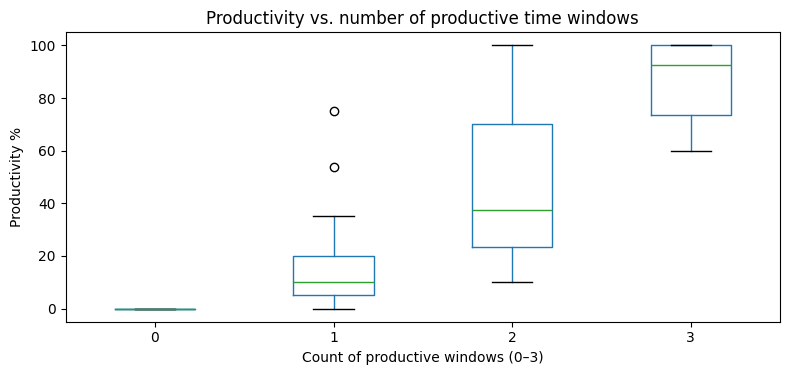

In [53]:
df["num_prod_slots"] = df[["prod_morning","prod_afternoon","prod_evening"]].sum(axis=1)
ax = df.boxplot(column="productivity_pct", by="num_prod_slots", grid=False)
plt.suptitle("")
plt.title("Productivity vs. number of productive time windows")
plt.xlabel("Count of productive windows (0–3)")
plt.ylabel("Productivity %")
plt.tight_layout()
plt.savefig("reports/figures/prod_vs_num_prod_slots.png", dpi=150)
plt.show()


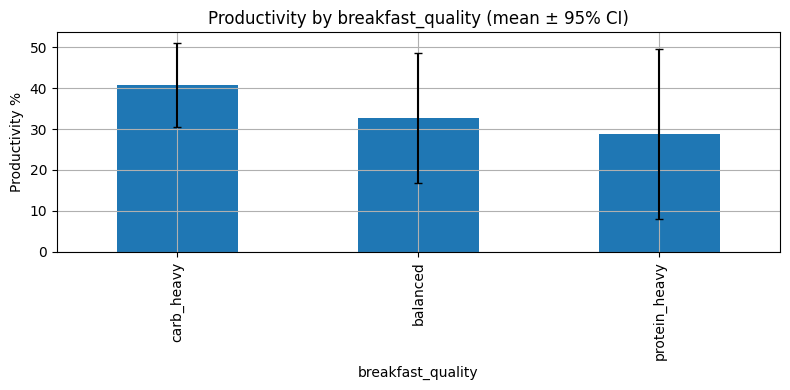

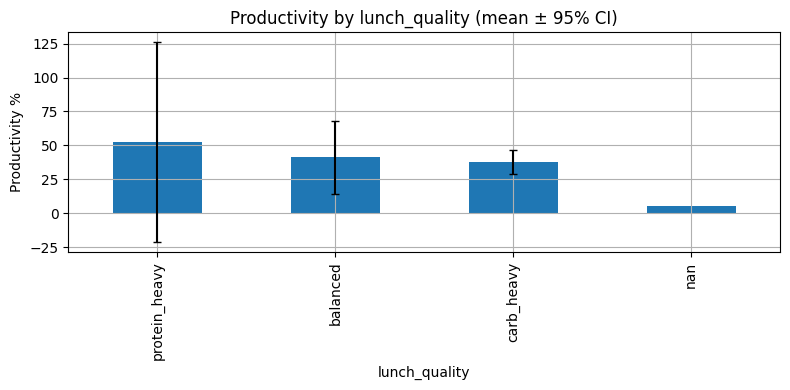

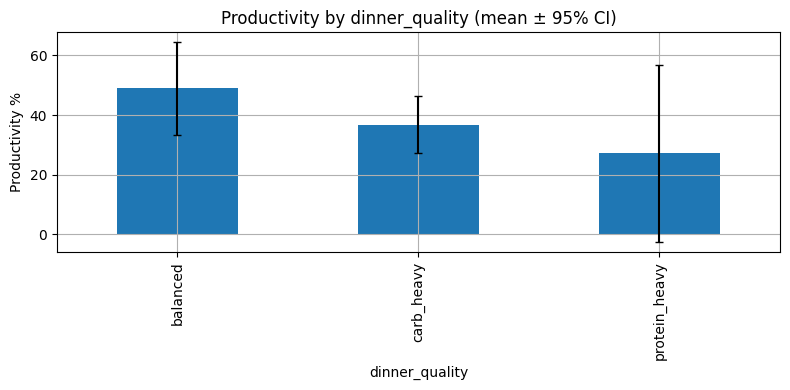

In [54]:
import numpy as np
def bar_mean_ci(col):
    g = df.groupby(col, dropna=False)["productivity_pct"]
    means = g.mean().sort_values(ascending=False)
    sem   = g.sem().reindex(means.index)
    ci95  = 1.96 * sem
    ax = means.plot(kind="bar", yerr=ci95, capsize=3)
    ax.set_title(f"Productivity by {col} (mean ± 95% CI)")
    ax.set_ylabel("Productivity %")
    plt.tight_layout()
    plt.savefig(f"reports/figures/prod_by_{col}_ci.png", dpi=150)
    plt.show()

for meal in ["breakfast_quality","lunch_quality","dinner_quality"]:
    if meal in df.columns:
        bar_mean_ci(meal)


In [55]:
import json
summary_path = Path("reports/eda_summary.json")
summary = json.loads(open(summary_path).read())

# Add weekday means
wd_means = df.groupby("weekday")["productivity_pct"].mean().dropna().round(2).to_dict()
summary["mean_prod_by_weekday"] = wd_means

# Add example p-values (if you ran the SciPy cells above, recompute once here)
from scipy import stats
def safe_pearson(a, b):
    s = df[[a,b]].dropna()
    if len(s) >= 3:
        r, p = stats.pearsonr(s[a], s[b])
        return {"r": round(float(r), 3), "p": float(f"{p:.3g}"), "n": int(len(s))}
    return None

summary["pearson_sleep_vs_prod"] = safe_pearson("sleep_duration_h", "productivity_pct")

with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print("Updated:", summary_path)


Updated: reports/eda_summary.json


In [56]:
# Helpers used by later cells
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FIG_DIR = Path("reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def _savefig(name, dpi=130):
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved: {path}")


Saved: reports/figures/prod_by_primary_mood_box.png
Median productivity by mood:
primary_mood
motivated      75.0
happy          47.0
sad            22.5
stressed       15.0
depressed       5.0
overwhelmed     5.0
Name: productivity_pct, dtype: float64


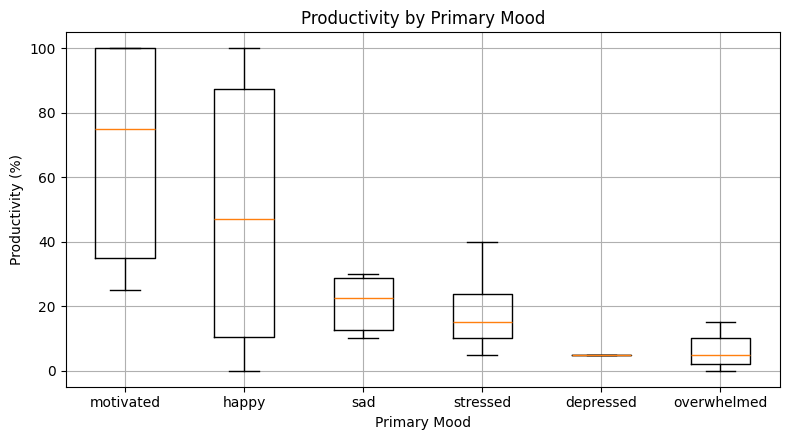

In [57]:
col_mood = "primary_mood"
col_y = "productivity_pct"

if col_mood in df.columns and col_y in df.columns:
    tmp = df[[col_mood, col_y]].dropna()
    # Order moods by median productivity (high → low) for readability
    med = tmp.groupby(col_mood)[col_y].median().sort_values(ascending=False)
    order = med.index.tolist()

    data = [tmp.loc[tmp[col_mood] == m, col_y].values for m in order]

    plt.figure(figsize=(8, 4.5))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title("Productivity by Primary Mood")
    plt.xlabel("Primary Mood")
    plt.ylabel("Productivity (%)")
    _savefig("prod_by_primary_mood_box.png")

    print("Median productivity by mood:")
    print(med.round(1))
else:
    print("Needed columns not found.")


Saved: reports/figures/prod_by_study_location.png
Means (±95% CI):
   both: 60.0  (n=11, CI≈±18.5)
   home: 40.9  (n=40, CI≈±10.9)
neither: 21.4  (n=18, CI≈±14.6)
 school: 15.0  (n=3, CI≈±19.6)


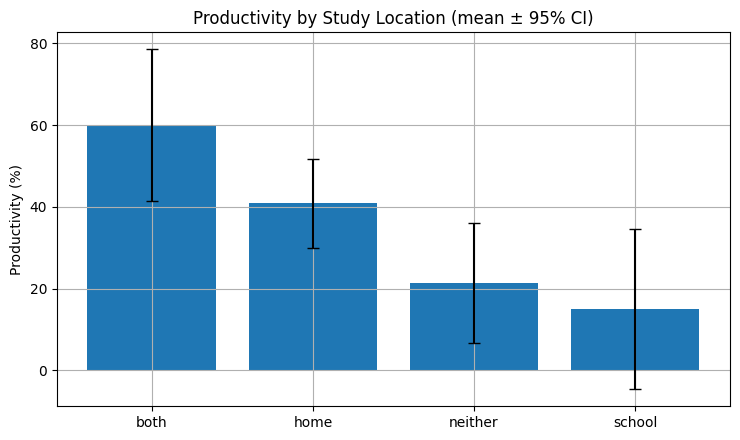

In [58]:
need = {"studied_at_home", "studied_at_school", "productivity_pct"}
if need.issubset(df.columns):
    loc = df.copy()
    h = loc["studied_at_home"] == 1
    s = loc["studied_at_school"] == 1
    loc["study_loc"] = np.select(
        [h & s, h & ~s, ~h & s, ~h & ~s],
        ["both", "home", "school", "neither"],
        default="unknown",
    )

    grp = loc.groupby("study_loc")["productivity_pct"]
    means = grp.mean()
    ns = grp.count()
    stds = grp.std()
    ses = stds / np.sqrt(ns.clip(lower=1))  # standard error
    ci95 = 1.96 * ses

    order = means.sort_values(ascending=False).index.tolist()

    plt.figure(figsize=(7.5, 4.5))
    x = np.arange(len(order))
    plt.bar(x, means[order], yerr=ci95[order], capsize=4)
    plt.xticks(x, order)
    plt.ylabel("Productivity (%)")
    plt.title("Productivity by Study Location (mean ± 95% CI)")
    _savefig("prod_by_study_location.png")

    print("Means (±95% CI):")
    for k in order:
        print(f"{k:>7s}: {means[k]:.1f}  (n={ns[k]}, CI≈±{ci95[k]:.1f})")
else:
    print("Needed columns not found.")


Saved: reports/figures/sleep_duration_vs_productivity.png
sleep_duration_h: slope=-7.75, intercept=97.56, r=-0.29, n=72
Saved: reports/figures/deep_sleep_vs_productivity.png
deep_sleep_pct: slope=-1.57, intercept=72.42, r=-0.14, n=72
Saved: reports/figures/rem_sleep_vs_productivity.png
rem_sleep_pct: slope=0.15, intercept=36.57, r=0.02, n=72


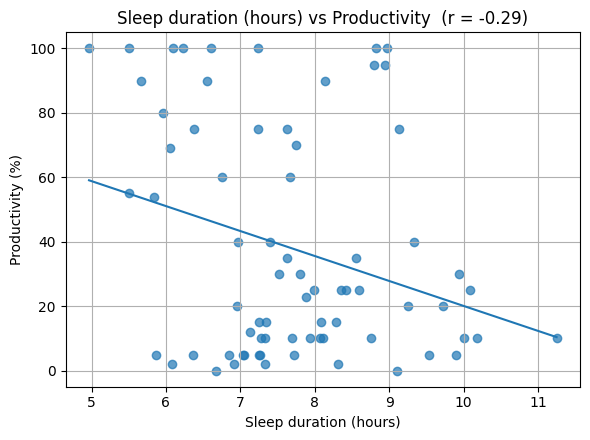

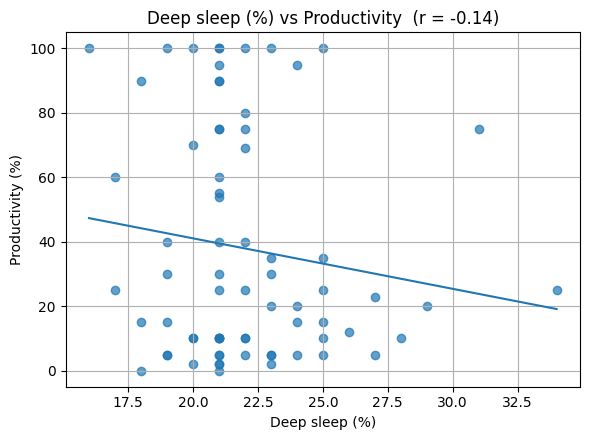

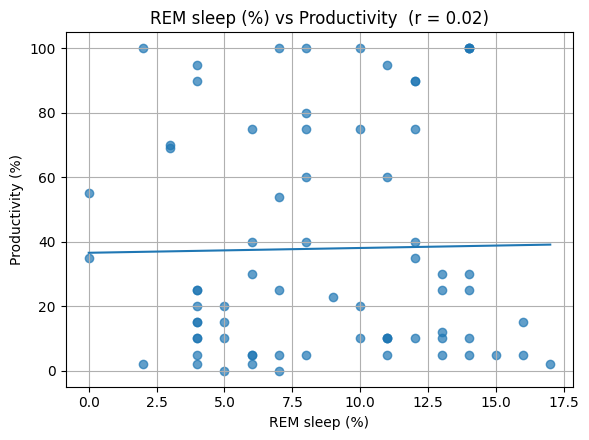

In [59]:
def scatter_fit(xcol, ycol="productivity_pct", xlabel=None, fname=None):
    if xcol not in df.columns or ycol not in df.columns:
        print(f"Missing needed columns for {xcol}.")
        return
    tmp = df[[xcol, ycol]].dropna()
    if len(tmp) < 3:
        print(f"Not enough data for {xcol}.")
        return
    x = tmp[xcol].values.astype(float)
    y = tmp[ycol].values.astype(float)

    # Fit a simple line
    slope, intercept = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    r = np.corrcoef(x, y)[0, 1]

    plt.figure(figsize=(6, 4.5))
    plt.scatter(x, y, alpha=0.7)
    plt.plot(x_line, y_line)
    plt.xlabel(xlabel or xcol)
    plt.ylabel("Productivity (%)")
    plt.title(f"{xlabel or xcol} vs Productivity  (r = {r:.2f})")
    _savefig(fname or f"{xcol}_vs_productivity.png")
    print(f"{xcol}: slope={slope:.2f}, intercept={intercept:.2f}, r={r:.2f}, n={len(x)}")

scatter_fit("sleep_duration_h", xlabel="Sleep duration (hours)", fname="sleep_duration_vs_productivity.png")
scatter_fit("deep_sleep_pct",   xlabel="Deep sleep (%)",        fname="deep_sleep_vs_productivity.png")
scatter_fit("rem_sleep_pct",    xlabel="REM sleep (%)",         fname="rem_sleep_vs_productivity.png")


Saved: reports/figures/when_most_productive_distribution.png
Percent of days by category:
when_most_productive_decoded
morning                      26.4%
morning_afternoon_evening    22.2%
evening                      13.9%
afternoon                    11.1%
morning_afternoon            11.1%
morning_evening               8.3%
afternoon_evening             5.6%
not_productive                1.4%
Name: count, dtype: object


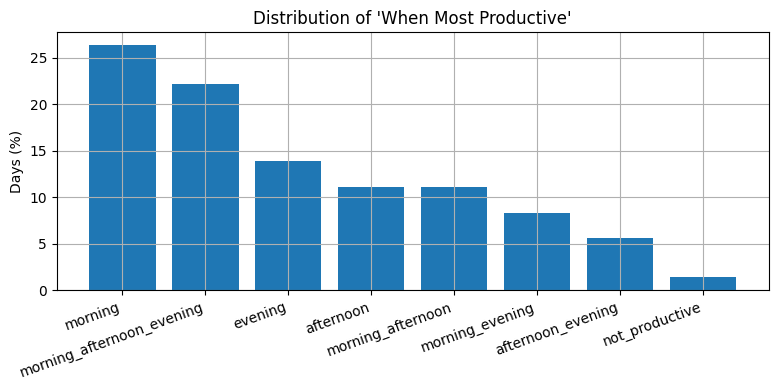

In [60]:
col = "when_most_productive_decoded"
if col in df.columns:
    counts = df[col].value_counts(dropna=False).sort_values(ascending=False)
    # Show percentages including NaN bucket if present
    total = counts.sum()
    pct = (100 * counts / total).round(1)

    plt.figure(figsize=(8, 4))
    plt.bar(pct.index.astype(str), pct.values)
    plt.ylabel("Days (%)")
    plt.title("Distribution of 'When Most Productive'")
    plt.xticks(rotation=20, ha="right")
    _savefig("when_most_productive_distribution.png")

    print("Percent of days by category:")
    print(pct.astype(str) + "%")
else:
    print("Column not found:", col)


Saved: reports/figures/breakfast_quality_distribution_by_prod_50.png
breakfast_quality:
                   >50.0%  ≤50.0%
breakfast_quality                
balanced             20.8    16.7
carb_heavy           70.8    68.8
protein_heavy         8.3    14.6
Saved: reports/figures/lunch_quality_distribution_by_prod_50.png
lunch_quality:
               >50.0%  ≤50.0%
lunch_quality                
balanced         12.5     6.4
carb_heavy       83.3    91.5
protein_heavy     4.2     2.1
Saved: reports/figures/dinner_quality_distribution_by_prod_50.png
dinner_quality:
                >50.0%  ≤50.0%
dinner_quality                
balanced          25.0    10.4
carb_heavy        70.8    79.2
protein_heavy      4.2    10.4


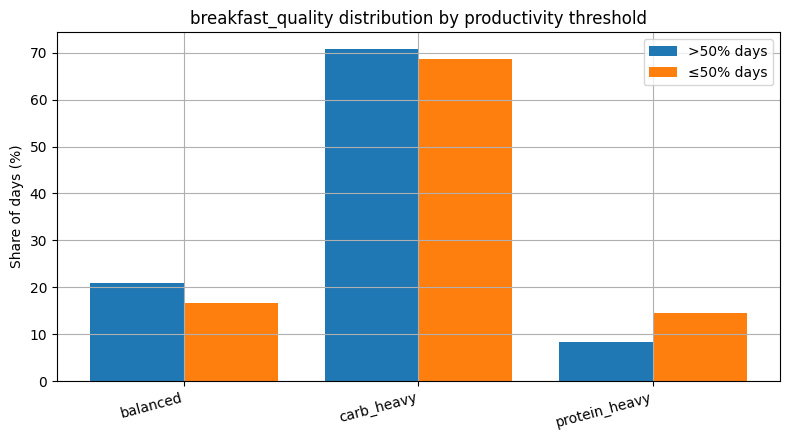

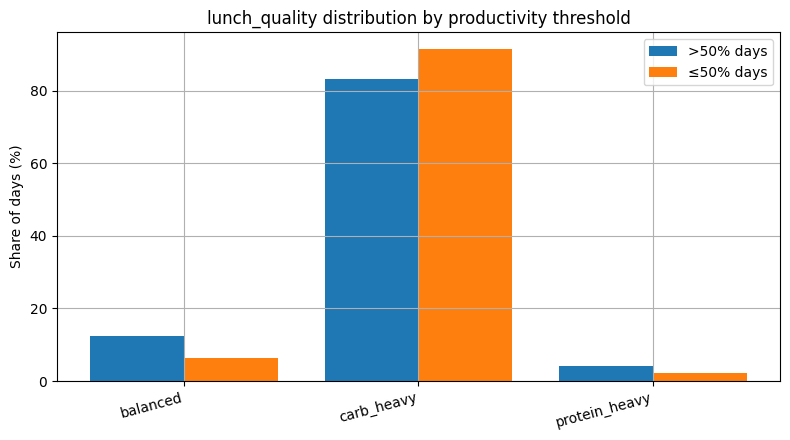

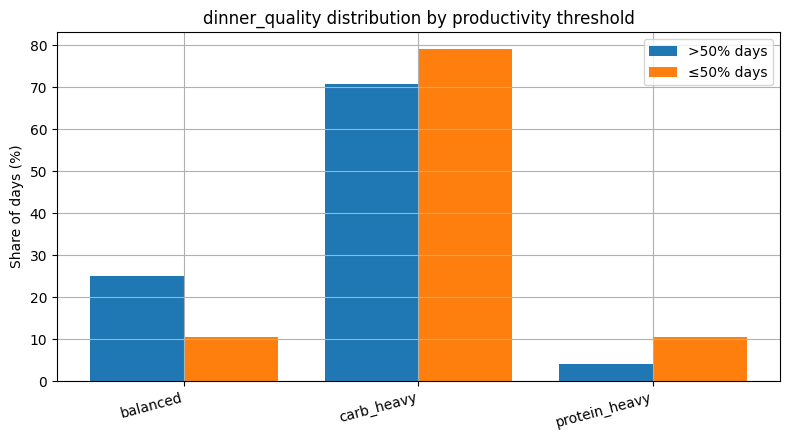

In [61]:
def meal_distribution_by_prod_threshold(meal_col, thresh=50.0):
    if meal_col not in df.columns or "productivity_pct" not in df.columns:
        print(f"Missing cols for {meal_col}")
        return

    tmp = df[[meal_col, "productivity_pct"]].dropna()
    if tmp.empty:
        print(f"No data for {meal_col}")
        return

    tmp["gt50"] = tmp["productivity_pct"] > thresh
    cats = sorted(tmp[meal_col].dropna().unique().tolist())
    dist_true = tmp.loc[tmp["gt50"], meal_col].value_counts(normalize=True).reindex(cats, fill_value=0.0)
    dist_false = tmp.loc[~tmp["gt50"], meal_col].value_counts(normalize=True).reindex(cats, fill_value=0.0)

    # Plot grouped bars
    idx = np.arange(len(cats))
    width = 0.4
    plt.figure(figsize=(8, 4.5))
    plt.bar(idx - width/2, 100*dist_true.values, width, label=f">{thresh:.0f}% days")
    plt.bar(idx + width/2, 100*dist_false.values, width, label=f"≤{thresh:.0f}% days")
    plt.xticks(idx, cats, rotation=15, ha="right")
    plt.ylabel("Share of days (%)")
    plt.title(f"{meal_col} distribution by productivity threshold")
    plt.legend()
    _savefig(f"{meal_col}_distribution_by_prod_{int(thresh)}.png")

    print(f"{meal_col}:")
    print(pd.DataFrame({
        f">{thresh}%": (100*dist_true).round(1),
        f"≤{thresh}%": (100*dist_false).round(1),
    }))

for meal_col in ["breakfast_quality", "lunch_quality", "dinner_quality"]:
    meal_distribution_by_prod_threshold(meal_col, thresh=50.0)


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _mean_ci_95(series):
    s = series.dropna().astype(float)
    n = len(s)
    if n == 0:
        return np.nan, np.nan, 0
    mean = float(s.mean())
    ci = 1.96 * (s.std(ddof=1) / np.sqrt(n)) if n > 1 else np.nan
    return mean, ci, n

def plot_meal_ci_with_counts(df, meal_col, out_name):
    order = ["balanced", "carb_heavy", "protein_heavy"]
    g = df.dropna(subset=[meal_col, "productivity_pct"]).copy()

    stats = [(_lab, *_mean_ci_95(g.loc[g[meal_col] == _lab, "productivity_pct"]))
             for _lab in order]
    labels = [t[0] for t in stats]
    means  = [t[1] for t in stats]
    cis    = [t[2] for t in stats]
    ns     = [t[3] for t in stats]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(x, means, yerr=cis, capsize=5)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Productivity %")
    ax.set_xlabel(meal_col)
    ax.set_title(f"Productivity by {meal_col} (mean ± 95% CI)")

    # place n labels above bars
    pad = (np.nanmax([m+c if np.isfinite(c) else m for m,c in zip(means, cis)]) or 0) * 0.03
    for xi, yi, n in zip(x, means, ns):
        if np.isfinite(yi):
            ax.text(xi, yi + (pad if pad > 0 else 1.0), f"n={n}", ha="center", va="bottom", fontsize=10)

    out = Path("reports/figures") / out_name
    out.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.close(fig)
    print("Wrote", out)

plot_meal_ci_with_counts(df, "breakfast_quality", "prod_by_breakfast_quality_ci.png")
plot_meal_ci_with_counts(df, "lunch_quality",     "prod_by_lunch_quality_ci.png")
plot_meal_ci_with_counts(df, "dinner_quality",    "prod_by_dinner_quality_ci.png")


Wrote reports/figures/prod_by_breakfast_quality_ci.png
Wrote reports/figures/prod_by_lunch_quality_ci.png
Wrote reports/figures/prod_by_dinner_quality_ci.png


**Phase 2 plan (Feature Engineering + Simple Models):**
- Rolling features: 3/7/14-day means and deltas for sleep, mood, interactions, meals.
- Encode cyclical time (weekday, minutes-after-midnight).
- One-hot / embeddings for mood categories; text sentiment from reflections.
- Baselines: 
  - Regression: predict productivity_pct with ridge/elastic net (report R², CV).
  - Classification: “>50% day” with logistic regression (report ROC-AUC, PR-AUC, CV).
- Statistical checks:
  - Two-sample t-tests or non-parametric alternatives on high- vs low-productivity groups (document p-values; caution on power).
  - Multiple-testing guard rails (report #tests; keep interpretation conservative).
